In [341]:
import numpy as np
import numpy.matlib
import seaborn as sns
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc #erfc/Q function
import math
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from IPython.display import clear_output


In [196]:
def sym_gen(num_sym, M):
    return np.random.randint(low=0, high = M, size=num_sym)

In [197]:
def base_wave(samps_per_sym, f, size, type_wave = 'cos'):
    if samps_per_sym/2 > f:
        t = np.arange(0,size,1/samps_per_sym)
        if type_wave == 'cos':
            return np.cos(2*np.pi*f*t)
        else:
            return np.sin(2*np.pi*f*t)
    else:
        return print('[ERROR] Smps/2 > f')

## Ruido
Temos que \\[\gamma = SNR = E_b/N_0\\] ou \\[\gamma = SNR = E_s/N_0\\]

Temos também que \\[P = L \times \frac{1}{N} \sum_{i=0}^{N-1}|s_i|^2\\]

Portanto,

\\[N_0 = P/\gamma\\]

In [198]:
def channel_awgn(sig, EbN0dB, samps_per_sym):
    gamma = 10**(EbN0dB/10)
    P=samps_per_sym*sum(abs(sig)**2)/len(sig) 
    N0=P/gamma 
    
    if np.isrealobj(sig):
        noise = np.sqrt(N0/2)*np.random.standard_normal(sig.shape)
    else:
        noise = np.sqrt(N0/2)*(np.random.standard_normal(sig.shape)+1j*np.random.standard_normal(sig.shape))

    rx_sig = sig + noise
    return rx_sig
    

In [199]:
def Q(x):
    return 0.5*erfc(x/np.sqrt(2))

In [396]:
def mpsk_mod(sym_arr, samps_per_sym, f, M):
    if math.log(M,2).is_integer():
        m = np.arange(0,M)
        I = 1/np.sqrt(2)*np.cos(m/M*2*np.pi)
        Q = 1/np.sqrt(2)*np.sin(m/M*2*np.pi)
        constellation = I + 1j*Q
        constellation2 = np.vstack((constellation, m))
        
        remap_sym_cons = constellation[sym_arr]
        remap_sym = np.repeat(remap_sym_cons,samps_per_sym)
        
        
        imag_sig = np.sin(2*np.pi*f*np.linspace(0,len(remap_sym)/samps_per_sym, len(remap_sym)))*(remap_sym.imag)
        real_sig = np.cos(2*np.pi*f*np.linspace(0,len(remap_sym)/samps_per_sym, len(remap_sym)))*remap_sym.real
        
        sig = real_sig-imag_sig
        
    else:
        return print('[ERROR] M-PSK is not possible')

    return sig, constellation2

In [397]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, cutoff, btype='low', fs=fs, analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [398]:
def demod_ncoh_psk(rx, samps_per_sym, f, nSym, order, fcut):
    carrier_cos = base_wave(samps_per_sym, f, nSym)
    bits_rx_cos = rx*carrier_cos

    carrier_sin = -base_wave(samps_per_sym, f, nSym, 'sin')
    bits_rx_sin = rx*carrier_sin

    Rx_cos = butter_lowpass_filter(bits_rx_cos, fcut, samps_per_sym, order)
    sig_rx_I = 2*Rx_cos[np.arange(samps_per_sym/2,len(Rx_cos),np.round((samps_per_sym))).astype(int)]
    
    
    Rx_sin = butter_lowpass_filter(bits_rx_sin, fcut, samps_per_sym, order)
    sig_rx_Q = 2*Rx_sin[np.arange(samps_per_sym/2,len(Rx_sin),np.round((samps_per_sym))).astype(int)]
    
    sig_rx = sig_rx_I+1j*sig_rx_Q
    
    return sig_rx

In [399]:
def demod_coh_psk(rx, samps_per_sym, f, nSym):
    carrier_cos = base_wave(samps_per_sym, f, 1)
    carrier_sin = -base_wave(samps_per_sym, f, 1, 'sin')
    
    sig_rx = np.array([])
    
    for array_sig in np.arange(0, len(rx), samps_per_sym):
        sig_rx_I = 2*np.trapz(rx[array_sig:array_sig+samps_per_sym]*carrier_cos, dx = 1/samps_per_sym)
        sig_rx_Q = 2*np.trapz(rx[array_sig:array_sig+samps_per_sym]*carrier_sin, dx = 1/samps_per_sym)
        rec = sig_rx_I+1j*sig_rx_Q
        sig_rx = np.append(sig_rx, rec)

    return sig_rx

In [400]:
def decision(constellation, rx):
    rx_sym = np.array([])
    for symb in rx:
        dif = np.absolute(symb-constellation[0])
        smallest_difference_index = dif.argmin()
        rx_symb = constellation[1][smallest_difference_index]
        rx_sym = np.append(rx_sym, rx_symb)
        
    return rx_sym.real

        

In [401]:
nSym = 1000
samps_per_sym = 1000
f = 10
M=8
syns = sym_gen(nSym,M)
a, cons = mpsk_mod(syns, samps_per_sym,f, M)
rx = channel_awgn(a, 20, samps_per_sym)

In [402]:
rec = demod_ncoh_psk(rx, samps_per_sym, f, nSym, 2, 1)
rec_coh = demod_coh_psk(rx, samps_per_sym, f, nSym)

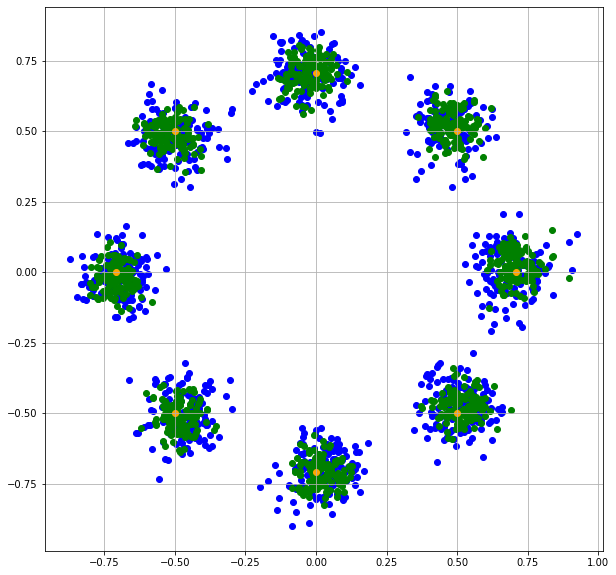

In [403]:
fig = plt.subplots(figsize = (10,10))
plt.scatter(rec.real, rec.imag, color = 'blue')
plt.scatter(rec_coh.real, rec_coh.imag, color = 'g')
plt.scatter(cons[0].real, cons[0].imag, color = 'orange')
plt.grid()

2-PSK
SNR = 16


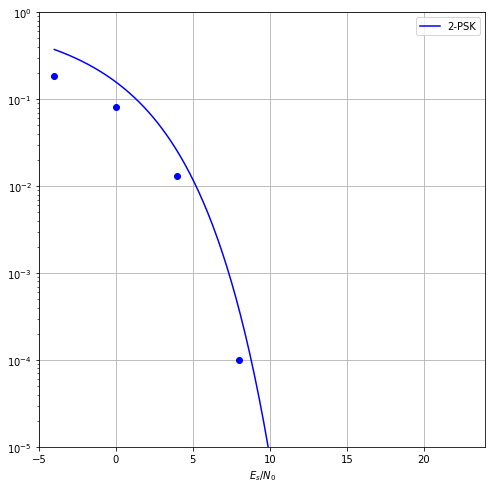

In [407]:
Ms = [2]
colors = {2: 'b', 4: 'r', 8: 'g', 16 : 'black'}
SNR_inicial = -4
SNR_final = 20
step = 4
EbN0dBs = np.arange(start=SNR_inicial,stop = SNR_final, step = step) # Eb/N0 range in dB for simulation
EbN0dBs2 = np.arange(start=SNR_inicial,stop = SNR_final, step = 0.1)
fig = plt.subplots(figsize=(8,8))
for M in Ms:
    
    nSym = 10000
    samps_per_sym = 1000
    f = 10
    syns = sym_gen(nSym,M)
    a, cons = mpsk_mod(syns, samps_per_sym,f, M)

    
    BER_sim_coh = np.zeros(len(EbN0dBs)) # simulated Bit error rates
    BER_sim_ncoh = np.zeros(len(EbN0dBs)) # simulated Bit error rates
    

    for j,EbN0dB in enumerate(EbN0dBs):
        clear_output(wait=True)
        print('{}-PSK'.format(M))
        print('SNR = {}'.format(EbN0dB))
        
        r = channel_awgn(a, EbN0dB, samps_per_sym)

        rec_coh = demod_coh_psk(r, samps_per_sym, f, nSym)
        rec_ncoh = demod_ncoh_psk(r, samps_per_sym, f, nSym, 2, 1)
        BER_sim_coh[j] = np.sum(decision(cons, rec_coh) != syns)/nSym #calculate BER
        #ER_sim_ncoh[j] = np.sum(decision(cons, rec_ncoh) != syns)/nSym #calculate BER


    BER_theory = 2*Q(np.sin(np.pi/M)*np.sqrt(10**(EbN0dBs2/10)*2))

    plt.semilogy(EbN0dBs,BER_sim_coh,color=colors[M],marker='o',linestyle='')
    #lt.semilogy(EbN0dBs,BER_sim_ncoh,color=colors[M],marker='x',linestyle='')
    plt.semilogy(EbN0dBs2,BER_theory,color=colors[M], marker='',linestyle='-',label=str(M)+'-PSK')
    plt.xlim(-5,24);
    plt.ylim(1e-5,1)
    plt.grid(True);
    plt.xlabel('$E_s/N_0$')
    plt.legend()


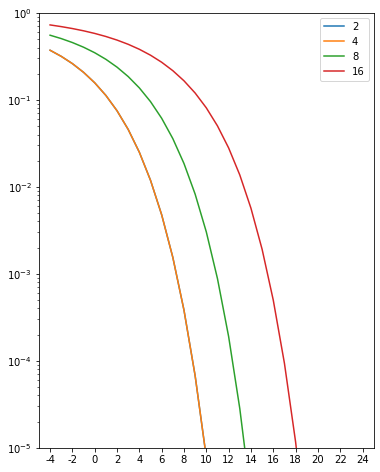

In [390]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


fig, ax = plt.subplots(figsize=(6,8))
for M in Ms:

    Pm = 2*Q(np.sqrt(2*math.log(M,2)*EbN0Lin)*np.sin(np.pi/M))
    ax.semilogy(EsN0dBs, Pm, label = str(M))
    ax.set_ylim([float(1e-5), float(1)])
    ax.set_xlim([-5, 25])
    ax.xaxis.grid(True, which='minor')
    
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

    ax.legend()